In [64]:
import torch
import cv2
import numpy as np
import clip
import matplotlib.pyplot as plt
from PIL import Image

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [21]:
def random_perspective(image, max_warp=0.1):
    """
    Apply a small random perspective transform to an image.

    Args:
        image (np.ndarray): Input image.
        max_warp (float): Maximum warp as a fraction of image size (0.1 = 10%).

    Returns:
        np.ndarray: Warped image.
    """
    h, w = image.shape[:2]

    # Define perturbation scale
    dx = int(w * max_warp)
    dy = int(h * max_warp)

    # Source points near the corners
    src_pts = np.float32([
        [0, 0],
        [w - 1, 0],
        [w - 1, h - 1],
        [0, h - 1]
    ])

    # Perturb the source points randomly
    dst_pts = np.float32([
        [np.random.randint(0, dx), np.random.randint(0, dy)],
        [w - 1 - np.random.randint(0, dx), np.random.randint(0, dy)],
        [w - 1 - np.random.randint(0, dx), h - 1 - np.random.randint(0, dy)],
        [np.random.randint(0, dx), h - 1 - np.random.randint(0, dy)]
    ])

    # Get perspective transform matrix
    M = cv2.getPerspectiveTransform(src_pts, dst_pts)

    # Warp the image
    warped = cv2.warpPerspective(image, M, (w, h), borderMode=cv2.BORDER_REFLECT101)

    return warped


'cuda'

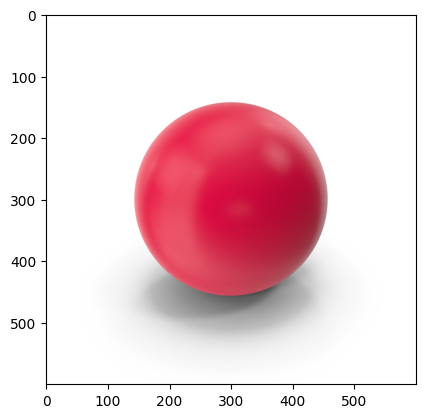

In [22]:
image = cv2.imread('images/red_ball.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)

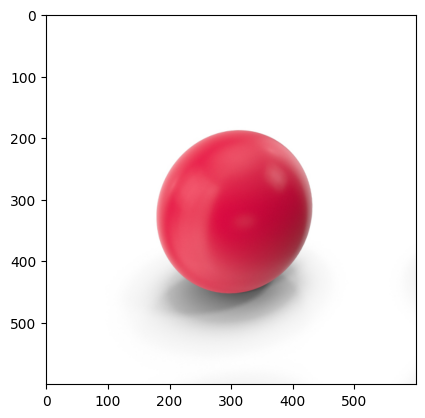

In [56]:
warped_image = random_perspective(image, max_warp=0.15)
plt.imshow(warped_image)

### Create a batch of images with slight perspective differences

In [62]:
model, preprocess = clip.load("ViT-B/32", device=device)

100%|███████████████████████████████████████| 338M/338M [01:14<00:00, 4.77MiB/s]


In [65]:
image_p = preprocess(Image.fromarray(image)).unsqueeze(0).to(device)

In [70]:
images = [random_perspective(image) for _ in range(10)]
images = [preprocess(Image.fromarray(image)) for image in images]
images = torch.stack(images, dim = 0).to(device)

In [81]:
with torch.no_grad():
    image_embeddings = model.encode_image(images).cpu()
general_embedding = torch.mean(image_embeddings, dim=0)

## LLM Agent

In [4]:
import os
from langchain_core.prompts import PromptTemplate, ChatPromptTemplate
from langchain_openai import ChatOpenAI
import dotenv
dotenv.load_dotenv()

llm = ChatOpenAI(
        api_key = os.environ['OPENAI_API_KEY'],
        model ='gpt-4o-mini',
        temperature = 0.1
)

prompt = PromptTemplate(
    template=""" You are a helpful assistant that reviews user commands and extracts only the object description contained in the command.
    For example the user might say 'Grab the red ball'. Your response should be : 'red ball'.

    User Command: {command}""",
    input_variables=["command"]
)

agent = prompt | llm

def get_object_description(command):
    return agent.invoke({"command": command}).content

In [5]:
get_object_description("Grab the red ball")

'red ball'

In [1]:
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt

In [2]:
path = './data_from_runs/data_1743688766_645412206/(1743688766, 719385623)/mask.png'
rgb_path = './data_from_runs/data_1743688766_645412206/(1743688766, 719385623)/rgb_image.png' 

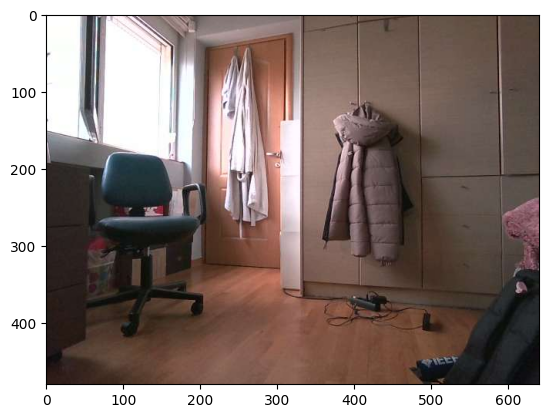

In [3]:
img = cv2.imread(rgb_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
mask = cv2.imread(path)
plt.imshow(img)

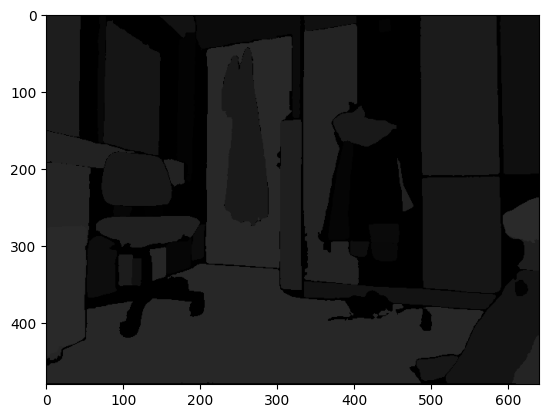

In [41]:
plt.imshow(mask)

In [6]:
np.unique(mask)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42], dtype=uint8)

(480, 640)


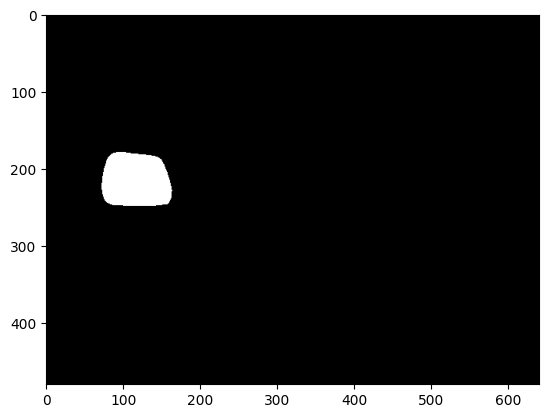

In [42]:
obj_0_mask = np.mean(np.where(mask == 24, 255, 0), axis=-1, keepdims=False).astype(np.uint8) #robe == 26
print(obj_0_mask.shape)
plt.imshow(obj_0_mask,cmap='gray')

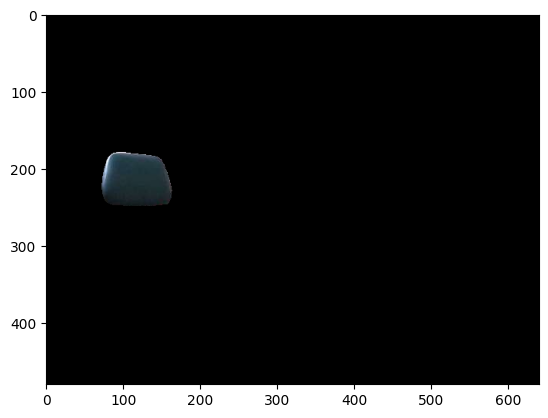

In [44]:
masked_img = cv2.bitwise_and(img, img, mask=obj_0_mask)
plt.imshow(masked_img)
